## LaD Final Squib
By Elmas Kat
2828399

#### Loading the data

The annotated data is loaded from a CSV file exported from ELAN.


In [3]:
import pandas as pd

path = r"C:\Users\KatElmas\OneDrive - van der Meij college\bureaublad\ElmasKat_phenomenacomplete.csv"
df = pd.read_csv(path)

df.head()

,Source,Speaker,Content
0,Selinay,Selinay,en toen stonden er allemaal politie mochten we...
1,Selinay,Selinay,nee maar ik [ ]
2,Selinay,Selinay,ohja wij dachten dat king charles erin zat [ ]
3,Selinay,Selinay,((laughs))
4,Selinay,Selinay,maar het was echt druk =


#### Annotation labels

Two labels are used:
- NS: narrative step
- NE: new episode

In [4]:
phen = df[df["Source"].str.contains("Phenomena", na=False)].copy()

phen["Label"] = phen["Content"].astype(str).str.extract(r"\b(NS|NE)\b")

phen = phen[phen["Label"].isin(["NS", "NE"])].copy()

phen[["Source","Speaker","Content","Label"]].head()

,Source,Speaker,Content,Label
306,Phenomena Selinay,Selinay,NE = New Episode Marker,NE
307,Phenomena Selinay,Selinay,NE = New Episode Marker,NE
308,Phenomena Selinay,Selinay,NS = Narrative Step Marker,NS
309,Phenomena Selinay,Selinay,NS = Narrative Step Marker,NS
310,Phenomena Selinay,Selinay,NS = Narrative Step Marker,NS


#### Frequency analysis

This section looks at how often each label occurs in the data.

In [5]:
def get_annotator(source):
    s = str(source).lower()
    if "carla" in s:
        return "carla"
    if "meleny" in s:
        return "meleny"
    if "_sel" in s:
        return "sel"   # Selinay as annotator
    if "_gul" in s:
        return "gul"   # Gultanem as annotator
    return "elmas"     # Phenomena Selinay / Phenomena Gultanem (me)

phen["Annotator"] = phen["Source"].apply(get_annotator)
phen["Annotator"].value_counts()

Annotator
elmas     15
carla     15
meleny    15
gul        8
sel        7
Name: count, dtype: int64

In [6]:
freq = pd.crosstab(phen["Annotator"], phen["Label"])
freq

Label,NE,NS
Annotator,,
carla,8,7
elmas,8,7
gul,4,4
meleny,7,8
sel,5,2


In [7]:
def turn_position(text):
    words = str(text).lower().split()
    for i in range(len(words) - 1):
        if words[i] == "en" and words[i+1] == "toen":
            return "Beginning" if i <= 1 else "Middle"
    return "No_en_toen"

# Calculating turn position on transcript-rows (not only Phenomena)
transcript = df[~df["Source"].str.contains("Phenomena", na=False)].copy()
transcript["TurnPosition"] = transcript["Content"].apply(turn_position)
transcript["TurnPosition"].value_counts()

TurnPosition
No_en_toen    291
Beginning      12
Middle          3
Name: count, dtype: int64

In [8]:
# Key in order to match
phen["key"] = phen["Speaker"].astype(str) + " | " + phen["Content"].astype(str)
transcript["key"] = transcript["Speaker"].astype(str) + " | " + transcript["Content"].astype(str)

# Adding turn position to phen
phen = phen.merge(transcript[["key", "TurnPosition"]], on="key", how="left")

# Turn position vs label 
pd.crosstab(phen[phen["Annotator"]=="carla"]["TurnPosition"], phen[phen["Annotator"]=="carla"]["Label"])

Label
TurnPosition


In [9]:
wide = phen.pivot_table(
    index="key",
    columns="Annotator",
    values="Label",
    aggfunc="first"
)

wide.head()

Annotator,carla,elmas,gul,meleny,sel
key,,,,,
Gultanem | NE = New Episode Marker,NE,NE,NE,NE,NaN
Gultanem | NS = Narrative Step Marker,NS,NS,NS,NS,NaN
Selinay | NE = New Episode Marker,NE,NE,NaN,NE,NE
Selinay | NS = Narrative Step Marker,NS,NS,NaN,NS,NS


#### Inter-annotator agreement

Cohen’s kappa is used to measure agreement between the two neutral annotators.

N items (Carla vs Meleny): 4
Cohen's kappa (C vs M): 1.0
Confusion matrix (rows=Carla, cols=Meleny):
 [[2 0]
 [0 2]]


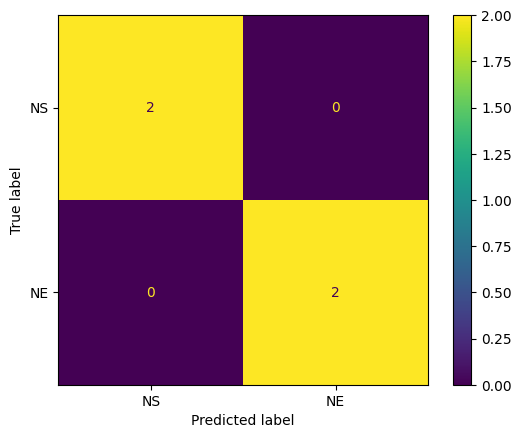

In [10]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

cm_data = wide.dropna(subset=["carla", "meleny"]).copy()

y_c = cm_data["carla"]
y_m = cm_data["meleny"]

kappa = cohen_kappa_score(y_c, y_m)
print("N items (Carla vs Meleny):", len(cm_data))
print("Cohen's kappa (C vs M):", round(kappa, 2))

cm = confusion_matrix(y_c, y_m, labels=["NS","NE"])
print("Confusion matrix (rows=Carla, cols=Meleny):\n", cm)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NS","NE"]).plot()

In [11]:
phen["Group"] = phen["Annotator"].replace({
    "sel": "speaker_annotators",
    "gul": "speaker_annotators",
    "carla": "neutral_annotators",
    "meleny": "neutral_annotators",
    "elmas": "researcher"
})

pd.crosstab(phen["Group"], phen["Label"])

Label,NE,NS
Group,,
neutral_annotators,15,15
researcher,8,7
speaker_annotators,9,6


In [12]:
subset = phen[phen["Group"].isin(["speaker_annotators", "neutral_annotators"])]
pd.crosstab(subset["Group"], subset["Label"])

Label,NE,NS
Group,,
neutral_annotators,15,15
speaker_annotators,9,6
